In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
# lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
# lat_rho = np.transpose(lat_rho, axes=(1, 0))
z_r = np.load('/home/z5297792/MRes/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
previous_file_idx = -1
TOTAL_NUM_DAYS = len(daydic)

# Lagrangian Methods

In [3]:
import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

def grid_finder(i_search, j_search, SEARCH_WIDTH):
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
    dataset = nc.Dataset(fname)
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    
    def within_search_width(i_offset, j_offset):
        return distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                        lat_rho[i_search + i_offset, j_search + j_offset], 
                        lon_rho[i_search + i_offset, j_search + j_offset]) < SEARCH_WIDTH / 2

    i_left, i_right = 0, 0
    j_down, j_up = 0, 0

    while i_search - i_left >= 0 and within_search_width(-i_left, 0):
        i_left += 1
    while i_search + i_right < lon_rho.shape[0] and within_search_width(i_right, 0):
        i_right += 1
    while j_search - j_down >= 0 and within_search_width(0, -j_down):
        j_down += 1
    while j_search + j_up < lon_rho.shape[1] and within_search_width(0, j_up):
        j_up += 1

    i_left = max(i_search - i_left + 1, 0)
    i_right = min(i_search + i_right, lon_rho.shape[0])
    j_down = max(j_search - j_down + 1, 0)
    j_up = min(j_search + j_up, lon_rho.shape[1])

    I, J = np.meshgrid(np.arange(i_left, i_right), np.arange(j_down, j_up))
    return I, J

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat, dlon = lat2_rad - lat1_rad, lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

def find_global_maxima(matrix):
    i_max, j_max = np.unravel_index(np.argmax(matrix, axis=None), matrix.shape)
    return i_max, j_max

def find_local_maxima(matrix):
    def is_local_maxima(matrix, i, j):
        rows, cols = matrix.shape
        value = matrix[i, j]
        if np.isnan(value):
            return False
        def is_valid_and_greater_than(value, neighbor):
            return not np.isnan(neighbor) and neighbor > value
        if i > 0 and is_valid_and_greater_than(value, matrix[i - 1, j]):
            return False
        if i < rows - 1 and is_valid_and_greater_than(value, matrix[i + 1, j]):
            return False
        if j > 0 and is_valid_and_greater_than(value, matrix[i, j - 1]):
            return False
        if j < cols - 1 and is_valid_and_greater_than(value, matrix[i, j + 1]):
            return False
        if i > 0 and j > 0 and is_valid_and_greater_than(value, matrix[i - 1, j - 1]):
            return False
        if i > 0 and j < cols - 1 and is_valid_and_greater_than(value, matrix[i - 1, j + 1]):
            return False
        if i < rows - 1 and j > 0 and is_valid_and_greater_than(value, matrix[i + 1, j - 1]):
            return False
        if i < rows - 1 and j < cols - 1 and is_valid_and_greater_than(value, matrix[i + 1, j + 1]):
            return False
        return True
    i_max, j_max, value_max = [], [], []
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if is_local_maxima(matrix, i, j):
                i_max.append(i)
                j_max.append(j)
                value_max.append(matrix[i, j])
    return i_max, j_max, value_max



### Load Eddy Data

In [4]:
edata = eddies['Eddy22'].iloc[5] #E22T5
t = extract_number(edata.name)

temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')

t_mod = t % 30
file_idx = np.floor(t/30)
if file_idx != previous_file_idx:
    
    fnumber = '0'+str(round(1461+ file_idx*30))
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_'+fnumber+'.nc'
    dataset = nc.Dataset(fname)
    
    u = np.load('/srv/scratch/z5297792/Climatology/u_v/u_'+fnumber+'.npy')
    u = np.transpose(u,axes=(3,2,1,0))
    v = np.load('/srv/scratch/z5297792/Climatology/u_v/v_'+fnumber+'.npy')
    v = np.transpose(v,axes=(3,2,1,0))
    vort = np.load('/srv/scratch/z5297792/Climatology/vorts/vort_'+fnumber+'.npy')
    vort = np.transpose(vort,axes=(3,2,1,0))
    temp = np.load('/srv/scratch/z5297792/Climatology/temps/temp_'+fnumber+'.npy') - np.repeat(temp_ave[:, :, :, np.newaxis], 30, axis=3)
    temp = np.transpose(temp,axes=(3,2,1,0))
    ocean_time = dataset.variables['ocean_time'][:]
    
    previous_file_idx = file_idx

### Choose DataField

In [41]:
import parcels
from datetime import timedelta
import xarray as xr

DataField = temp

DEPTH_LVL = 5
u_lvl = u[:,DEPTH_LVL,:,:]
v_lvl = v[:,DEPTH_LVL,:,:]
DataField = DataField[:,DEPTH_LVL,:,:]
data = {
    "U": u_lvl, "V": v_lvl, "temp": DataField
}
dims = {
    "lon": lon_rho, "lat": lat_rho, 'time': ocean_time
}
fieldset = parcels.FieldSet.from_data(data, dims, mesh="spherical", allow_time_extrapolation=True,)

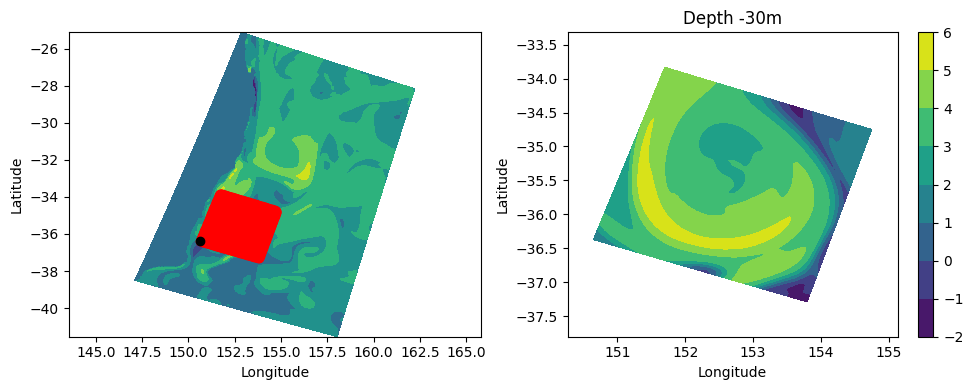

In [42]:
SEARCH_WIDTH = 300000

i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)
I, J = grid_finder(i_search, j_search, SEARCH_WIDTH)

lon = lon_rho[J, I]
lat = lat_rho[J, I]

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
# Plot 1: Contourf and Scatter
axs[0].contourf(fieldset.U.lon, fieldset.U.lat, fieldset.temp.data[t_mod, :, :])
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
axs[0].axis('equal')
axs[0].scatter(lon, lat, color='r')
axs[0].scatter(lon.flatten()[0], lat.flatten()[0], color='k')

# for i, txt in enumerate(daydic['Day6'].index):
#     axs[0].text(daydic['Day6'].Lon[i], daydic['Day6'].Lat[i], txt)

# Plot 2: Contourf of vorticity level
contour_plot = axs[1].contourf(lon, lat, DataField[t_mod, J, I])
axs[1].set_title('Depth '+str(round(z_r[150,150,DEPTH_LVL]))+'m')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
axs[1].axis('equal')
fig.colorbar(contour_plot, ax=axs[1])

plt.tight_layout()
plt.show()

### Compute Lagrangian Components

In [43]:
DAYS = 10 # Runtime length

SampleParticle = parcels.JITParticle.add_variable("temperature")
def SampleT(particle, fieldset, time):
    particle.temperature = fieldset.temp[time, particle.depth, particle.lat, particle.lon]
pset = parcels.ParticleSet(
    fieldset=fieldset, pclass=SampleParticle, lon=lon.flatten(), lat=lat.flatten(), time=ocean_time[0]
)
output_file = pset.ParticleFile(name="/srv/scratch/z5297792/zarr_files/SampleDataField.zarr", outputdt=timedelta(hours=1))
pset.execute(
    [parcels.AdvectionRK4, SampleT], runtime=timedelta(days=DAYS), dt=timedelta(minutes=5), output_file=output_file,
)

INFO: Output files are stored in SampleDataField.zarr.
100%|██████████| 864000.0/864000.0 [00:44<00:00, 19532.29it/s]


In [44]:
# # Optional Plot
# Particle_data = xr.open_zarr("SampleDataField.zarr")
# plt.figure()
# ax = plt.axes()
# # ax.plot(Particle_data.lon[0:6161:200,:].T, Particle_data.lat[0:6161:200,:].T, c="k", zorder=1)
# DataField_scatter = ax.scatter(Particle_data.lon, Particle_data.lat, c=Particle_data.temperature, cmap=plt.cm.coolwarm, zorder=2)
# plt.plot(pset.lon[0], pset.lat[0], "ko")
# plt.colorbar(DataField_scatter)
# plt.show()


### LAVD Calculation

In [50]:
from scipy.interpolate import interp1d
import zarr
Particle_DataField = zarr.open("/srv/scratch/z5297792/zarr_files/SampleDataField.zarr", mode='r')
Curlz_t = Particle_DataField['temperature'][:].T
tspan = np.linspace(ocean_time[0],ocean_time[DAYS-1],DAYS*24)

Curlz_avg_t = np.mean(Curlz_t, axis=1)

# # Using Grid Average
# Curlz_avg_t = []
# for t in range(DAYS):
#     Curlz_avg_t.append(np.mean(DataField[t, J, I]))
# minutes_per_day = 24 * 60
# total_minutes = DAYS * minutes_per_day
# avg_per_day = Curlz_avg_t
# daily_times = np.linspace(0, DAYS, len(avg_per_day))
# new_times = np.arange(0, DAYS, 1/24)
# interpolator = interp1d(daily_times, avg_per_day, kind='linear', fill_value='extrapolate')
# Curlz_avg_t = interpolator(new_times)

# IVD = Curlz_t - Curlz_avg_t[:, np.newaxis]

# LAVD = abs(np.mean(IVD, axis=0))

fill = np.abs(Curlz_t - Curlz_avg_t[:, np.newaxis])
LAVD = np.trapezoid(fill, x=tspan, axis=0)

### Plot with Contour

In [46]:
def extract_contour(level_to_extract, plot):
    for level_paths in plot.allsegs:
        for path in level_paths:
            xt = path[:, 0]
            yt = path[:, 1]
            return xt, yt
    else:
        return [], []

def matrix_range(matrix):
    return np.max(matrix) - np.min(matrix)

from scipy.spatial import ConvexHull
from shapely.geometry import Point, Polygon
def IsContourConvex(xt, yt, DeficiencyThresh):
    points = list(zip(xt, yt))
    hull = ConvexHull(points, qhull_options='QJ')
    HullArea = hull.volume  # In 2D, volume is the area
    polygon = Polygon(points)
    Area = polygon.area
    if Area == 0:
        return False
    AreaDeficiency = abs(HullArea - Area) / Area * 100
    return AreaDeficiency <= DeficiencyThresh

def IsContourClosed(xt, yt):
    return len(xt) >= 3 and len(yt) >= 3 and xt[0] == xt[-1] and yt[0] == yt[-1]

def is_point_inside_contour(x_coords, y_coords, px, py):
    contour = Polygon(zip(x_coords, y_coords))
    point = Point(px, py)
    return contour.contains(point)

def find_global_maxima(matrix):
    i_max, j_max = np.unravel_index(np.argmax(matrix, axis=None), matrix.shape)
    return i_max, j_max

def max_closed_convex_contour_finder(lonc, latc, lon, lat, LAV, num_contours):
    xc_max = lonc
    yc_max = latc
    data_range = matrix_range(LAV)
    largest_contour_xt = []
    largest_contour_yt = []
    for k in range(1, num_contours + 1):
        level_to_extract = np.max(LAV) - k * data_range / num_contours
        fig, ax = plt.subplots()
        c = ax.contour(lon, lat, LAV, levels=[level_to_extract], linewidths=1e-10, colors='k')
        plt.close(fig)
        xt, yt = extract_contour(level_to_extract, plot=c)
        if IsContourClosed(xt, yt) and IsContourConvex(xt, yt, DeficiencyThresh=10):
            if is_point_inside_contour(xt, yt, xc_max, yc_max):
                if len(xt) > len(largest_contour_xt):
                    largest_contour_xt, largest_contour_yt = xt, yt
    return largest_contour_xt, largest_contour_yt

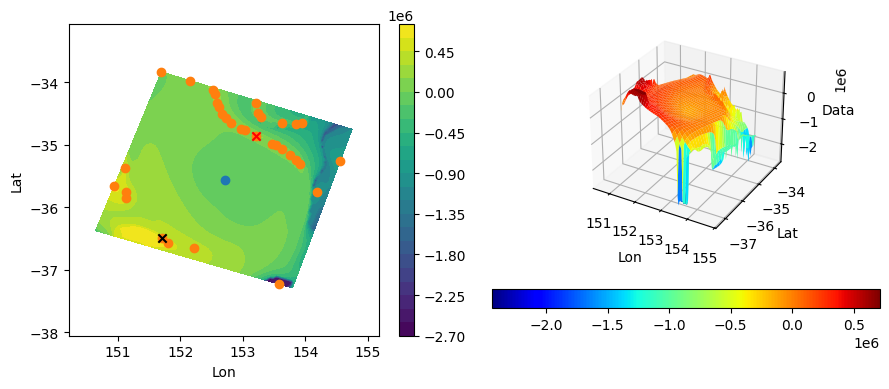

In [51]:
a, b = I.shape
dat = np.reshape(LAVD, (a, b))

fig = plt.figure(figsize=(9, 4))

# 2D contour plot
ax1 = fig.add_subplot(121)
contour = ax1.contourf(lon, lat, dat, levels=30)#, cmap='coolwarm')

plt.scatter(edata.Lon, edata.Lat)
i_local_max, j_local_max, value_max = find_local_maxima(dat)
plt.scatter(lon[i_local_max,j_local_max], lat[i_local_max,j_local_max])
i_max, j_max = find_global_maxima(dat)
plt.scatter(lon[i_max,j_max], lat[i_max,j_max], marker='x', color='k')

R = distance(lat[i_local_max,j_local_max], lon[i_local_max,j_local_max], edata.Lat, edata.Lon)
idx = np.argmin(R)
i_closest_max, j_closest_max = i_local_max[idx], j_local_max[idx]
plt.scatter(lon[i_closest_max,j_closest_max], lat[i_closest_max,j_closest_max], marker='x', color='r')

lonc, latc = lon[i_closest_max,j_closest_max], lat[i_closest_max,j_closest_max]
xt, yt = max_closed_convex_contour_finder(lonc, latc, lon, lat, dat, num_contours=100)
ax1.plot(xt, yt ,linewidth=2, color='r')

fig.colorbar(contour, ax=ax1)
ax1.axis('equal')
ax1.set_xlabel('Lon')
ax1.set_ylabel('Lat')

# 3D surface plot
ax2 = fig.add_subplot(122, projection='3d')
surf = ax2.plot_surface(lon, lat, dat, cmap='jet')
fig.colorbar(surf, ax=ax2, orientation='horizontal')
ax2.set_xlabel('Lon')
ax2.set_ylabel('Lat')
ax2.set_zlabel('Data')

# Display the plot
plt.tight_layout()
plt.show()